## Initializing weights Part 1

<img src="jenga.jpg" alt="Jenga about to fall over" width="250">

In this blog, let's explore some initializing methods on weights to train better. Our model can train well with a good initialization because close to all the activations become zeroes. Thanks to the Pytorch hooks we learned from the last blog, we can look into activation statistics as we try different techniques. This blog is based on [lesson 17](https://course.fast.ai/Lessons/lesson17.html) of the FastAI course.

First, we import libraries and do required setups.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'

!pip -q install torcheval
!pip -q install datasets

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.xtras import *

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.2 MB/s eta 0:00:00


We've been using Hugging Face Datasets, but let's try Pytorch's datasets this time. This way, we do not have to convert the Pyarrow format into tensors every time we use the data. So, it is faster for slow CPUs like Kaggle or Google Colab.

In [ ]:
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

trn_ds = datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=ToTensor()
)

val_ds = datasets.FashionMNIST(
    root=".",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
from torch.utils.data import DataLoader
set_seed(42)
bs = 1024

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [ ]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

Before we apply any initialization method, let's try to train and see what happens.

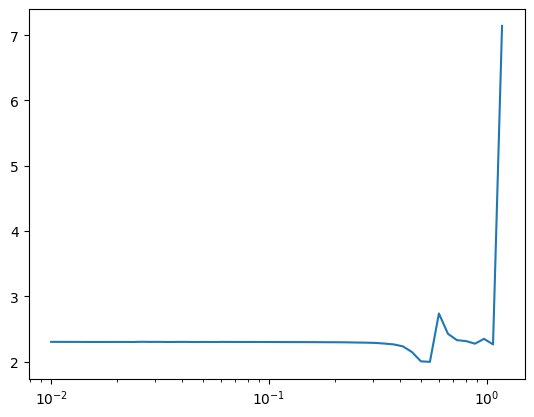

In [ ]:
set_seed(1)
model = get_model()
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

After training, we want to look at the statistics of the weights all the time, so we make a callback for it. This way, we do not have to call `stat.plot_stats` after training.

In [ ]:
class ShowStatsCB(Callback):
    def after_fit(self, learn):
        astats.plot_stats(figsize=(8, 3))

In [ ]:
set_seed(1)
metrics = MetricsCB(accuracy=MulticlassAccuracy(device='cpu'))
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=False), astats, ShowStatsCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.01, cbs=cbs)

accuracy,loss,epoch,train,time
0.100,2.303,0,True,00:16
0.100,2.302,0,False,00:01
0.124,2.301,1,True,00:16
0.154,2.300,1,False,00:01


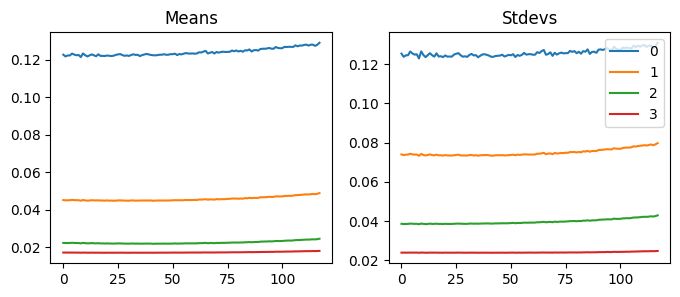

In [ ]:
learn.fit(2)

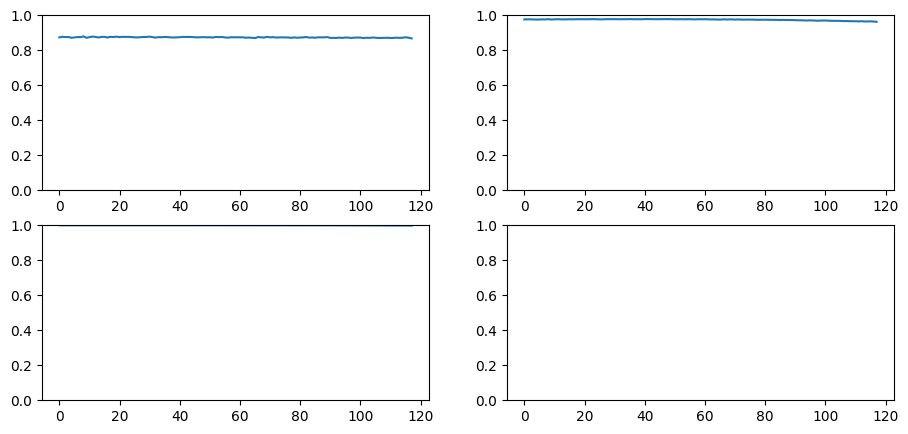

In [ ]:
astats.dead_chart()

This isn't good. Reducing the learning rate does not do anything because it is not training at all. Looking at activation statistics, we can see that they are very close to zeros. We can also check the dead chart; almost all the activations are zeroes. So what's going on here?

## Matrix multiplications

So, let's see what happens if we repeatedly perform matrix multiplication on a given matrix. If we execute this fifty times, all the values become `nan`s, which means they are too large for the computers. Therefore, if we have a model with fifty layers, we would get a model full of `nan`s. Do you know how we can fix this issue? We can perform matrix multiplications with smaller values to prevent values from exploding.

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

So, if we try to multiply by .01 to a new matrix, we get zeroes.

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100) * .01
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

However, if we multiply by .1, we get numbers. So, .1 is a magic number for us.

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100) * .1
x[0:5,0:5]

tensor([[-1.22, -0.63,  1.26, -0.47,  0.27],
        [-0.92, -0.66,  0.18,  0.05, -0.04],
        [-0.40, -0.52,  0.63, -0.09, -0.17],
        [-0.17, -0.20, -0.31, -0.41,  0.08],
        [ 0.47,  0.53, -0.67, -0.10,  0.06]])

## Glorot/Xavier init

According to [Understanding the difficulty of training deep feedforward neural networks](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) written by Xavier Glorot and Yoshua Bengio, we can initialize weights by multiplying them by the square root of the number of inputs to stabilize calculations. The paper used uniform distribution, but we can use normal distribution, which still works. This trick also appears in [Efficient Backprop](https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf) by Yann Lecun et al. section 4.6 initializing the weights. In both papers, the goal is to make the mean of zero and the standard deviation of 1.

In [ ]:
x.mean(), x.std()

(tensor(0.00), tensor(0.61))

First, we initialize weights, `w`, with normal distribution with the mean of 0 and the standard deviation of 1. Then, we multiply `w` by $1/\sqrt{n_{in}}$ where $n_{in}$ is a number of inputs.
$$w = w * \frac{1}{\sqrt{n_{in}}}$$

In other words, `w` is normally distributed with the mean of 0 and the standard deviation of $1/\sqrt{n_{in}}$ or the variance of $1/n_{in}$.

$$w \sim \mathcal{N}(0, \frac{1}{n_{in}})$$

How did they come up with this number? We can try to find mean and standard deviations ourselves from matrix multiplications. When we change the size, `sz`, of the input matrix, `x`, the standard deviation is pretty close to the `sz`. We can try different sizes.

In [ ]:
def get_stats(epochs = 100, sz = 100, init = 1., act = None, seed = None):
    if seed is not None: set_seed(seed)
    mean, sqr = 0., 0.
    for _ in range(epochs):
        x = torch.randn(64, sz) * init
        a = torch.randn(sz)
        y = x @ a
        if act is not None: y = act(y)
        mean += y.mean().item()
        sqr  += y.pow(2).mean().item()
    return mean / epochs, sqr / epochs

In [ ]:
get_stats()

(-0.04464139200747013, 99.57821556091308)

In [ ]:
get_stats(sz = 200)

(-0.005759633108973503, 197.81238624572754)

In [ ]:
get_stats(sz = 1000)

(0.7149963945150375, 1005.3396026611329)

That is very cool. We can keep the mean of 0 and the standard deviation of 1 and train deep neural networks! However, we cannot use this initialization because we will use the relu activation function, which messes up the statistics! What do you think we should do?

## Kaiming/He init

We can use Kaiming/He initialization with relu! This method came from [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852) by Kaiming He et al. We initialize this way:

$$w \sim \mathcal{N}(0, \frac{2}{n_{in}})$$

Where `w` is the weights are distributed as a normal distribution with the mean of 0 and the standard deviation of $\sqrt{2/n_{in}}$ or the variance of $2/n_{in}$ where $n_{in}$ is the number of inputs.


In [ ]:
get_stats(act=nn.ReLU())

(4.105671746730804, 52.16908494949341)

In [ ]:
get_stats(sz = 200, act=nn.ReLU())

(5.568780157566071, 97.80967510223388)

In [ ]:
get_stats(sz = 1000, act=nn.ReLU())

(12.306093001365662, 485.7778285217285)

Compared to Glorot init, standard deviations are halved. We can also see that the mean is not zero anymore. What's going on? We are left with only positive numbers because relu clips all the negative numbers. Therefore, we cannot have the mean of zero anymore. The only way to get a zero mean is to have all the zeroes as activations, but the standard deviation will also be zero.

Now that we can use an initialization method, let's try to improve our previous model with Kaiming init.

In [ ]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [ ]:
def _kaiming_init_(w):
    # For convolutions, inputs start with index 1
    st = (2 / np.prod(w.shape[1:])) ** .5
    with torch.no_grad():
        return w.normal_(0, st)

In [ ]:
def relu_(x): x.clamp_(0)

In [ ]:
def kaiming_init_(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): _kaiming_init_(m.weight)

In [ ]:
set_seed(1)
model = get_model()
model[0][0].weight.mean(), model[0][0].weight.std()

(tensor(0.01, grad_fn=<MeanBackward0>), tensor(0.18, grad_fn=<StdBackward0>))

We can apply Kaiming init with `apply` method. We can see that it worked by looking at the mean and the standard deviation of the activations before and after initialization.

In [ ]:
model.apply(kaiming_init_);

In [ ]:
model[0][0].weight.mean(), model[0][0].weight.std()

(tensor(0.02, grad_fn=<MeanBackward0>), tensor(0.45, grad_fn=<StdBackward0>))

accuracy,loss,epoch,train,time
0.504,1.476,0,True,00:16
0.764,0.646,0,False,00:02
0.802,0.538,1,True,00:15
0.808,0.530,1,False,00:01


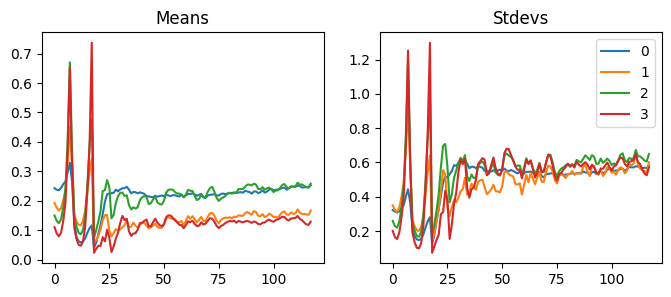

In [ ]:
set_seed(1)
model = get_model().apply(kaiming_init_)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

It's still not training very well. Although weights are normalized, images are not. So, we can normalize the data with callbacks.

In [ ]:
class BatchTfmCB(Callback):
    def before_batch(self, learn):
        xb, yb = learn.batch
        xb = (xb - xb.mean()) / xb.std()
        learn.batch = xb, yb

accuracy,loss,epoch,train,time
0.634,1.089,0,True,00:17
0.823,0.487,0,False,00:01
0.848,0.416,1,True,00:16
0.846,0.416,1,False,00:02


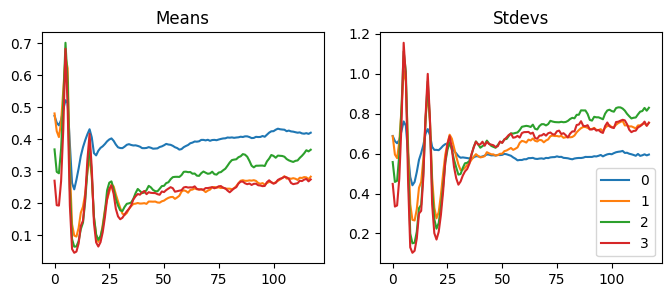

In [ ]:
set_seed(1)
model = get_model().apply(kaiming_init_)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs + [BatchTfmCB()])
learn.fit(2)

That's an improvement. We almost achieved 85% accuracy with two epochs.

We can also transform the inputs as transform before creating dataloaders. Using this method, we do not have to normalize data every batch.

In [ ]:
def batch_tfm(img): return (ToTensor()(img) - xmean) / xstd

In [ ]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

In [ ]:
trn_ds = datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=batch_tfm
)

val_ds = datasets.FashionMNIST(
    root=".",
    train=False,
    download=True,
    transform=batch_tfm
)

In [ ]:
trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
it = iter(dt)
next(it)
xb,yb = next(it)
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([3, 3, 3, 4, 6, 7, 6, 8, 6, 1]))

In [ ]:
xb.mean(), xb.std()

(tensor(-0.02), tensor(0.99))

In [ ]:
set_seed(1)
model = get_model().apply(kaiming_init_)
cbs = [DeviceCB(), metrics, ProgressCB(plot=False), astats]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

accuracy,loss,epoch,train,time
0.626,1.112,0,True,00:18
0.814,0.525,0,False,00:01
0.844,0.425,1,True,00:17
0.850,0.417,1,False,00:02


## General ReLU

We now create flexible `GeneralRelu` because the mean was not zero with Kaiming init. This version of relu allows us to subtract a number and do a leaky relu. Instead of clamping negative numbers, leaky relu uses a negative slope.

In [ ]:
class GeneralRelu(nn.Module):
    def __init__(self, leaky=None, sub=None, max_val=None):
        super().__init__()
        self.relu = nn.ReLU() if leaky is None else nn.LeakyReLU(leaky)
        self.sub = 0. if sub is None else sub
        self.max_val = max_val

    def forward(self, x):
        x = self.relu(x)
        x -= self.sub
        if self.max_val is not None:
            x.clamp_max_(self.max_val)
        return x

Let's look at what it looks like by plotting this function.

In [ ]:
def plot_func(f, min=-4., max=4.):
    x = torch.linspace(min, max, 100)
    y = f(x)
    plt.plot(x, y)
    plt.grid(True, which='both', ls='-')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

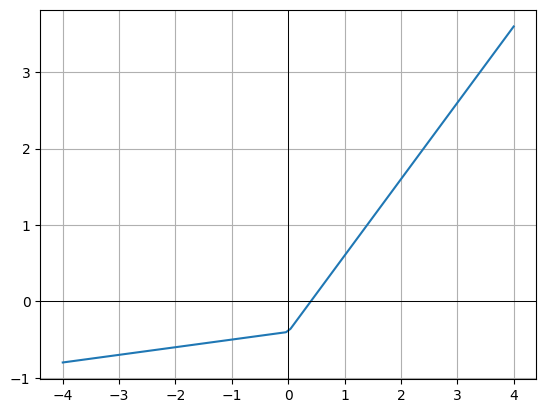

In [ ]:
gr = GeneralRelu(.1, .4)
plot_func(gr)

We can also look at this version's mean and standard deviation.

In [ ]:
get_stats(act=GeneralRelu(.1, .4))

(3.269775085449219, 49.65711633682251)

Before we use `GeneralRelu`, we have to modify our `conv` and `get_model` functions to use different activation functions.

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=None):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act is not None: res = nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act=nn.ReLU, filters=None):
    if filters is None: filters = [1, 8, 16, 32, 64]
    layers = [conv(filters[i], filters[i+1], act=act) for i in range(len(filters)-1)]
    return nn.Sequential(*layers, conv(filters[-1], 10, act=None), nn.Flatten()).to(def_device)

Now, we are ready to see how it performs. Let's also try some other values, too.

In [ ]:
get_stats(act=GeneralRelu(.1, .4), seed=1)

(3.2273051607608796, 50.619369144439695)

accuracy,loss,epoch,train,time
0.518,1.320,0,True,00:18
0.796,0.541,0,False,00:01
0.834,0.449,1,True,00:17
0.845,0.421,1,False,00:02
0.867,0.366,2,True,00:18
0.858,0.397,2,False,00:01
0.875,0.339,3,True,00:17
0.869,0.358,3,False,00:01
0.886,0.312,4,True,00:19
0.876,0.353,4,False,00:02


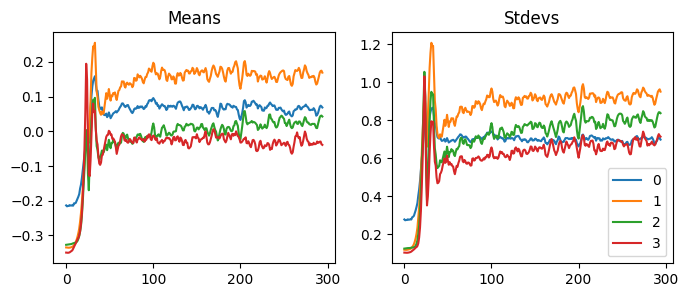

In [ ]:
set_seed(1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=False), astats, ShowStatsCB()]
model = get_model(act=partial(GeneralRelu, .1, .4))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

In [ ]:
get_stats(act=GeneralRelu(.05, .5), seed=1)

(3.3271772360801695, 49.40698293685913)

accuracy,loss,epoch,train,time
0.168,nan,0,True,00:17
0.100,nan,0,False,00:01
0.100,nan,1,True,00:16
0.100,nan,1,False,00:02
0.100,nan,2,True,00:18
0.100,nan,2,False,00:01
0.100,nan,3,True,00:16
0.100,nan,3,False,00:01
0.100,nan,4,True,00:16
0.100,nan,4,False,00:02


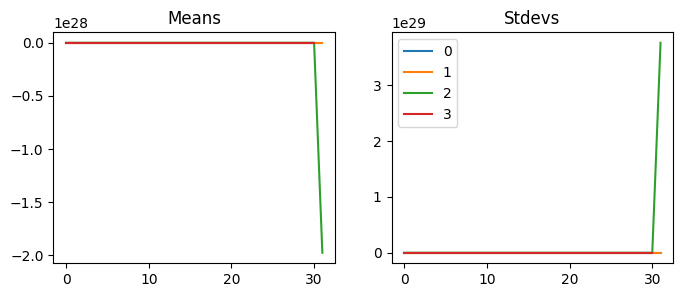

In [ ]:
set_seed(1)
model = get_model(act=partial(GeneralRelu, .05, .5))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

In [ ]:
get_stats(act=GeneralRelu(.05, .7), seed=1)

(3.127177233695984, 48.11611066818237)

accuracy,loss,epoch,train,time
0.506,1.379,0,True,00:17
0.793,0.560,0,False,00:01
0.836,0.446,1,True,00:17
0.850,0.412,1,False,00:01
0.866,0.367,2,True,00:18
0.854,0.408,2,False,00:01
0.876,0.338,3,True,00:19
0.868,0.370,3,False,00:01
0.889,0.304,4,True,00:18
0.865,0.369,4,False,00:01


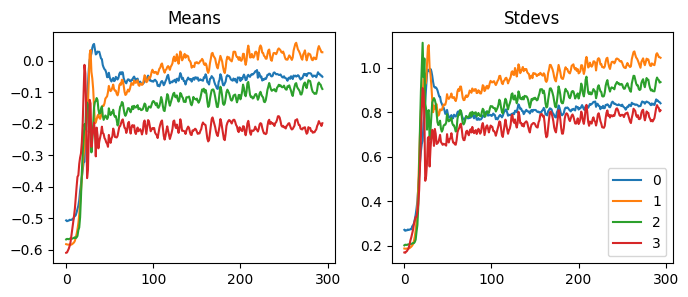

In [ ]:
set_seed(1)
model = get_model(act=partial(GeneralRelu, .05, .7))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

When we use `GeneralRelu(.05, .9)`, the mean and the std are similar to others, but the activations collapse. So, do the mean and the standard deviations not matter at all? Let's keep trying other values.

In [ ]:
get_stats(act=GeneralRelu(.05, .9), seed=1)

(2.927177308797836, 46.90524224281311)

accuracy,loss,epoch,train,time
0.100,nan,0,True,00:17
0.100,nan,0,False,00:01
0.100,nan,1,True,00:16
0.100,nan,1,False,00:02
0.100,nan,2,True,00:17
0.100,nan,2,False,00:01
0.100,nan,3,True,00:16
0.100,nan,3,False,00:01
0.100,nan,4,True,00:16
0.100,nan,4,False,00:02


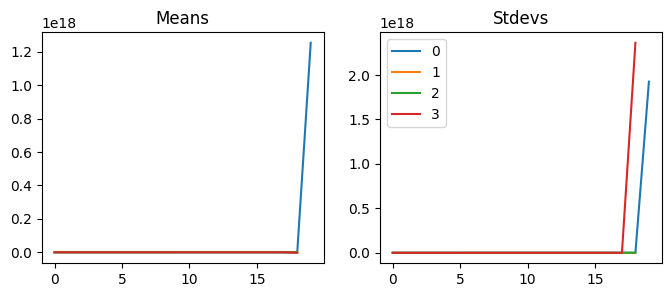

In [ ]:
set_seed(1)
model = get_model(act=partial(GeneralRelu, .05, .9))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

In [ ]:
get_stats(act=GeneralRelu(.2, .5), seed=1)

(2.727560875415802, 51.89185791015625)

accuracy,loss,epoch,train,time
0.516,1.351,0,True,00:18
0.781,0.585,0,False,00:01
0.833,0.453,1,True,00:17
0.848,0.411,1,False,00:02
0.867,0.366,2,True,00:20
0.866,0.376,2,False,00:01
0.874,0.343,3,True,00:17
0.859,0.387,3,False,00:02
0.885,0.314,4,True,00:18
0.867,0.359,4,False,00:01


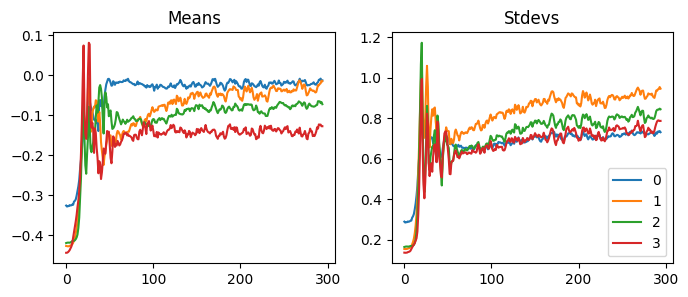

In [ ]:
set_seed(1)
model = get_model(act=partial(GeneralRelu, .2, .5))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

In [ ]:
get_stats(act=GeneralRelu(.2, .46), seed=1)

(2.767560924291611, 52.11166482925415)

accuracy,loss,epoch,train,time
0.553,1.237,0,True,00:17
0.786,0.547,0,False,00:01
0.837,0.446,1,True,00:19
0.847,0.419,1,False,00:01
0.867,0.367,2,True,00:18
0.843,0.424,2,False,00:01
0.876,0.344,3,True,00:18
0.870,0.365,3,False,00:01
0.885,0.315,4,True,00:17
0.864,0.370,4,False,00:01


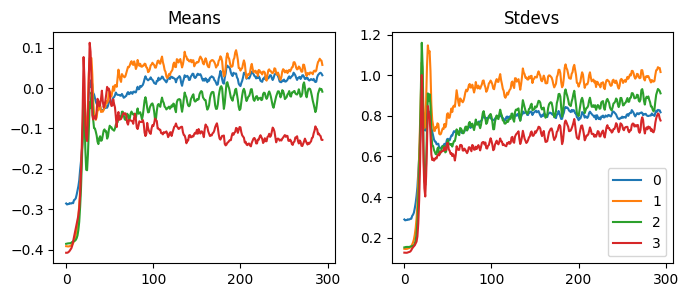

In [ ]:
set_seed(1)
model = get_model(act=partial(GeneralRelu, .2, .46))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

In [ ]:
get_stats(act=GeneralRelu(.2, .4), seed=1)

(2.827560887336731, 52.44737192153931)

accuracy,loss,epoch,train,time
0.259,nan,0,True,00:19
0.100,nan,0,False,00:03
0.100,nan,1,True,00:17
0.100,nan,1,False,00:01
0.100,nan,2,True,00:16
0.100,nan,2,False,00:01
0.100,nan,3,True,00:17
0.100,nan,3,False,00:02
0.100,nan,4,True,00:16
0.100,nan,4,False,00:01


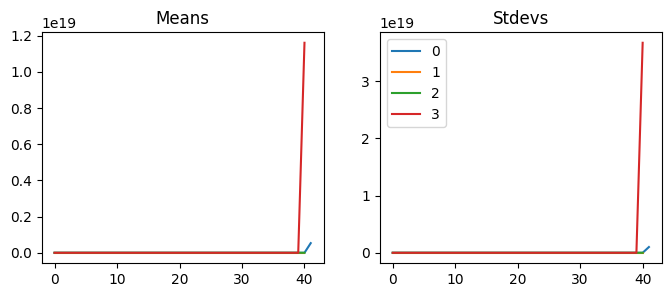

In [ ]:
set_seed(1)
model = get_model(act=partial(GeneralRelu, .2, .4))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

In [ ]:
get_stats(act=GeneralRelu(.3, .35), seed=1)

(2.4778165701031685, 55.52612455368042)

accuracy,loss,epoch,train,time
0.285,nan,0,True,00:20
0.100,nan,0,False,00:02
0.100,nan,1,True,00:17
0.100,nan,1,False,00:01
0.100,nan,2,True,00:17
0.100,nan,2,False,00:01
0.100,nan,3,True,00:17
0.100,nan,3,False,00:02
0.100,nan,4,True,00:18
0.100,nan,4,False,00:01


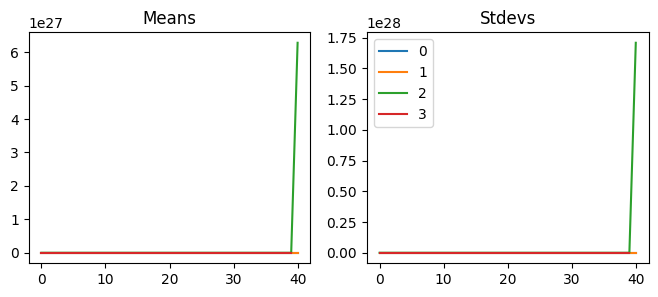

In [ ]:
set_seed(1)
model = get_model(act=partial(GeneralRelu, .3, .35))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

In [ ]:
get_stats(act=GeneralRelu(.3, .5), seed=1)

(2.3278166237473488, 54.80528106689453)

accuracy,loss,epoch,train,time
0.588,1.117,0,True,00:17
0.787,0.543,0,False,00:02
0.838,0.443,1,True,00:19
0.854,0.410,1,False,00:01
0.864,0.377,2,True,00:18
0.860,0.400,2,False,00:01
0.871,0.356,3,True,00:19
0.861,0.384,3,False,00:01
0.879,0.332,4,True,00:17
0.858,0.388,4,False,00:01


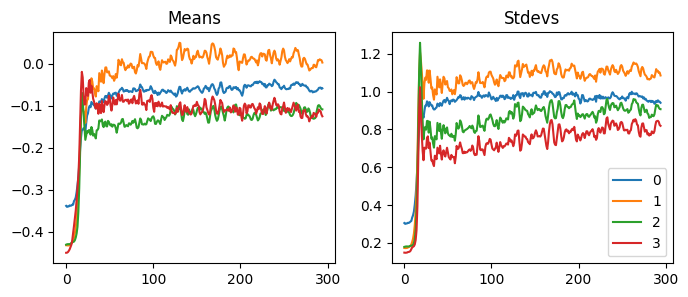

In [ ]:
set_seed(1)
model = get_model(act=partial(GeneralRelu, .3, .5))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

Reducing the mean to closer to zero did not always work out. Also, using different seed values sometimes made the model untrainable. For instance, using .2 and .4 with seed one does not work, but it works well without seed or using other seed values. Also, depending on the seed, the accuracy fluctuates a lot.

We can hypothesize that if we use an immense value for the leaky relu, the function becomes too linear, and the model cannot calculate helpful predictions. If we pay close attention to the statistics, we can see that all the mean and the standard deviation shifted early in the training to find a good spot.

Some good values to use are `(.1, .4)`, `(.5, .7)`, and `(.2, .4)`, but there can be other values.

In [ ]:
get_stats(act=GeneralRelu(.2, .4), seed=42)

(2.706548626422882, 47.42090078353882)

accuracy,loss,epoch,train,time
0.592,1.111,0,True,00:18
0.805,0.539,0,False,00:02
0.833,0.452,1,True,00:17
0.840,0.442,1,False,00:01
0.861,0.381,2,True,00:20
0.857,0.393,2,False,00:02
0.870,0.355,3,True,00:17
0.869,0.363,3,False,00:01
0.884,0.321,4,True,00:17
0.866,0.364,4,False,00:02


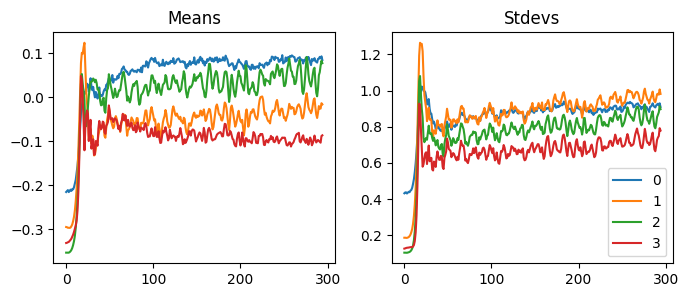

In [ ]:
set_seed(42)
model = get_model(act=partial(GeneralRelu, .2, .4))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

## Conclusion

In this blog, we learned about different initialization techniques, such as Glorot/Xavier init, Kaiming/He init, and trying `GeneralRelu` with different arguments. We also learned how important it is to have the mean of zero and the standard deviation of one for our activations. Now that we have learned Kaiming init, we can train deeper networks without vanishing or crashing activations.

Next time, we will learn about Layer-wise Sequential Unit-Variance (LSUV), layer normalization, and batch normalization.